We compare the sensitivity obtained from the approximate vs the full lensing models

In [161]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

from iminuit import Minuit

from multiprocessing import Pool, shared_memory
from functools import partial
import tqdm


from lens_map import *
import gaussian_source as src
import random_deflection

from scipy import stats


arcmin = np.pi/(180*60.)
arcsec = np.pi/(180*60.*60.)
microarcsec = 1e-6*arcsec

pc_in_km = 3.08568e+13
Gpc_in_km = 1e9*pc_in_km
AU_in_km = 1.49598e+08 
r_sun = 696340 # solar radius [km]

# Setting up the observation

In [163]:
# Observational Details
N = 96 # Points sampled
T = 48 # hours
dt = T / N # hours

t_evals = np.arange(N)*dt
#print(t_evals)
t_evals -= 0.9*np.amax(t_evals)
#t_evals = np.zeros(5)
print(t_evals)


[-42.75 -42.25 -41.75 -41.25 -40.75 -40.25 -39.75 -39.25 -38.75 -38.25
 -37.75 -37.25 -36.75 -36.25 -35.75 -35.25 -34.75 -34.25 -33.75 -33.25
 -32.75 -32.25 -31.75 -31.25 -30.75 -30.25 -29.75 -29.25 -28.75 -28.25
 -27.75 -27.25 -26.75 -26.25 -25.75 -25.25 -24.75 -24.25 -23.75 -23.25
 -22.75 -22.25 -21.75 -21.25 -20.75 -20.25 -19.75 -19.25 -18.75 -18.25
 -17.75 -17.25 -16.75 -16.25 -15.75 -15.25 -14.75 -14.25 -13.75 -13.25
 -12.75 -12.25 -11.75 -11.25 -10.75 -10.25  -9.75  -9.25  -8.75  -8.25
  -7.75  -7.25  -6.75  -6.25  -5.75  -5.25  -4.75  -4.25  -3.75  -3.25
  -2.75  -2.25  -1.75  -1.25  -0.75  -0.25   0.25   0.75   1.25   1.75
   2.25   2.75   3.25   3.75   4.25   4.75]


# Approximate model analysis

In this section we model the signal using the "perturbative" model. The fake data will be generated either using the same perturbative model, or using the full lensing solution. 


In [164]:
from scipy import interpolate


def get_mu_gaussian_source(y, params):
    peak_mag, r_source_angular = params
    #print(peak_mag*src.analytic_gaussian_source_magnification(0.))
    #print(y/r_source_angular)
    #print("Peak mag parameter = ", peak_mag)
    #print("yvals = ", y)
    #print("yvals = ", y)
    return(np.array([peak_mag*src.analytic_gaussian_source_magnification(-ypos/r_source_angular) for ypos in y]))


c_sample = np.geomspace(1e1, 1e4, 101)
universal_autocorrelator = np.load("../CausticMicrolensing/Josh/universal_autocorrelator.npy")


def get_universal_interpolator(c):
    """
    For a given value of the concentration parameter construct a function that computes the autocorrelation function 
    for the signal for a substructure mass M and at lag r.
    """
    min_index = np.abs(c_sample-c).argmin()
    interpolator = interpolate.interp1d(universal_autocorrelator[min_index, 0], universal_autocorrelator[min_index, 1],
                                    fill_value = (universal_autocorrelator[min_index, 0, 0], 0),
                                    kind = 'cubic')    

    def universal_interpolator(M, r):
        return M**(1/3)*interpolator(r/M**(1/3))


    return(universal_interpolator)

def smooth_max(x):
    x = np.asarray(x)
    return(np.sum(x*np.exp(x))/np.sum(np.exp(x)))
"""
def smooth_max(x, p=5):
    x = np.asarray(x)
    return(np.power(np.sum(np.power(x,p)),1./p))
"""
def gen_cov(params, y_evals):
    """
    y_evals = angualr coordinates of the source in the source plane
    """
    Nt = len(y_evals)

    phi_222 = params['phi_222']
    M = params['M']
    c = params['c']
    DS = params['DS'] # in Gpc
    angular_source_radius = params['R']
    
    universal_interpolator = get_universal_interpolator(c)
    
    # Assign values to the diagonal
    cov_mat = np.diag(universal_interpolator(M, 0)*np.ones((Nt)))

    """
    diag_indices = np.arange(Nt)
    for i in range(1, Nt):
        cov_mat[diag_indices[:-i], diag_indices[i:]] =  universal_interpolator(M, i*dt*v)
        cov_mat[diag_indices[i:], diag_indices[:-i]] =  universal_interpolator(M, i*dt*v)
    """

    
    
    for i in range(Nt):
        for j in range(i,Nt):
            
            # the length scale of the fluctuations is in the lens plane in microarcsec
            # the covariance can be non-positive definite if the wrong max function is used...
            r = np.abs(np.sqrt(2.*np.abs(y_evals[i])/phi_222)-np.sqrt(2.*np.abs(y_evals[j])/phi_222))
            #r = max(r, np.sqrt(2.*np.abs(angular_source_radius)/phi_222))
            r = smooth_max([r, np.sqrt(2.*np.abs(angular_source_radius)/phi_222)])
            # universal interpolator takes coord in km
            r *= microarcsec*DS*Gpc_in_km
            #print(r)
            cov_mat[i,j] = universal_interpolator(M, r)
            cov_mat[j,i] = cov_mat[i,j]
    return cov_mat


# Toy model functions
def generate_model(params, y_evals):
    """
    Returns the model mean and covariance matrix for parameters x and data time stamps t_evals
    """
    N = len(y_evals)

    angular_source_radius = params['R']
    phi_11 = params['phi_11'] 
    phi_222 = params['phi_222']
    M = params['M']
    c = params['c']
    frac = params['dm_mass_fraction']
    
    
    g = 2 / (phi_11 ** 2 * phi_222)
    peak_mag = np.sqrt(g / angular_source_radius)/1e4 
    mean_mu = get_mu_gaussian_source(y_evals, [1e4*peak_mag, angular_source_radius])


    # these are also model parameters in principle
    # Surface Density and Gradient
    #k0 = 0.83 # dimensionless
    A = phi_11**2 #4.*(1-k0)**2 # prefactor 
    
    cov = gen_cov(params,y_evals)

    

    # SHOULDNT THIS SCALE LIKE THE SQUARE OF CLUMPY DM?
    cov = frac**2 * A**2 * mean_mu[:, None]**2*cov*mean_mu[None, :]**2
    #cov = 0.5*(cov + cov.T)
    #print(np.max(cov-cov.T))
    return mean_mu, cov

"""
I had to introduce some extra parameters into the simple model; I am fixing these to better match our original test analysis set up
"""

fixed_params = {'phi_11': 0.8,  'c': 1000, 'DS' : 1.79, }

def gen_model(x):
    noise, peak_mag, source_velocity, source_radius, M, frac= x
    M = 10**M

    R = source_radius*r_sun/(fixed_params['DS']*Gpc_in_km)/microarcsec # angular radius in microarcsec
    mu_peak = 1e4*peak_mag

    # the lightcurve for a gaussian peaks at y/R = -0.54 
    phi_222 = 2.*src.analytic_gaussian_source_magnification(-0.540902)**2/(R*fixed_params['phi_11']**2 * mu_peak**2)
    input_params = {'R': R, 'phi_11':fixed_params['phi_11'], 'phi_222': phi_222, 'M': M, 'c': fixed_params['c'], \
                    'dm_mass_fraction': frac, 'DS' :fixed_params['DS']}

    y_evals = -t_evals*1e3*3600*source_velocity/(fixed_params['DS']*Gpc_in_km)/microarcsec
    
    mean, cov = generate_model(input_params, y_evals)
    
    return mean, cov

def NegLL(x):
    mean, cov = gen_model(x)
    try:
        out = -2*stats.multivariate_normal.logpdf(fake_data, mean = mean, cov = cov, allow_singular = True)
    except:
        return np.inf
    return out

def Profiled(param_index, param_value):

    profile_bounds = np.copy(bounds)
    profile_bounds[param_index] = param_value

    opt = optimize.differential_evolution(NegLL, bounds, tol = 0, atol = 1e-2, polish = False, disp = True, init = 'sobol')

    m = Minuit(NegLL, opt.x)
    for i in range(profile_bounds.shape[0]):
        m.limits['x'+str(i)] = profile_bounds[i]

    m.migrad()
    return m.fval

## Fake data from approximate model

In [166]:
bounds = np.array([[5, 15], [.9, 1.1], [1, 1], [50, 50], [-10, -1], [0.0001, 1]])

param_vec = [10, 1, 1, 50, -6, 1e-2]
true_mean, true_cov = gen_model(param_vec)

generator = stats.multivariate_normal(mean = true_mean, cov = true_cov, allow_singular = True)
fake_data = generator.rvs()

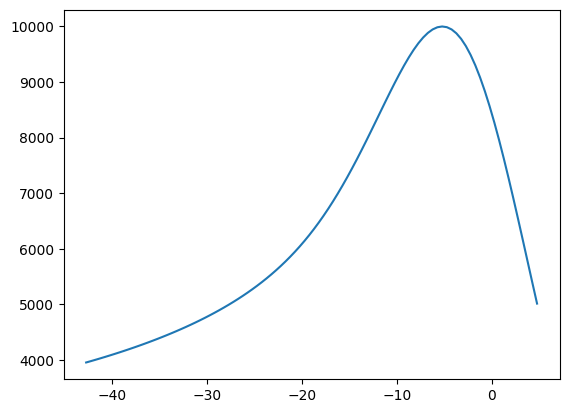

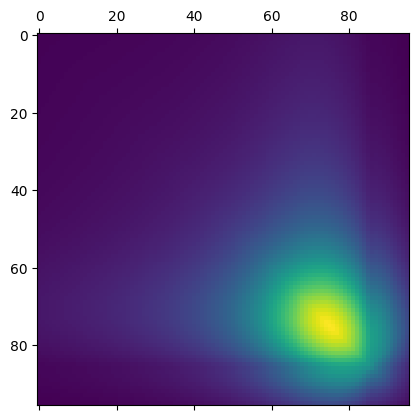

In [167]:
plt.plot(t_evals,true_mean)
plt.show()
plt.matshow(true_cov)

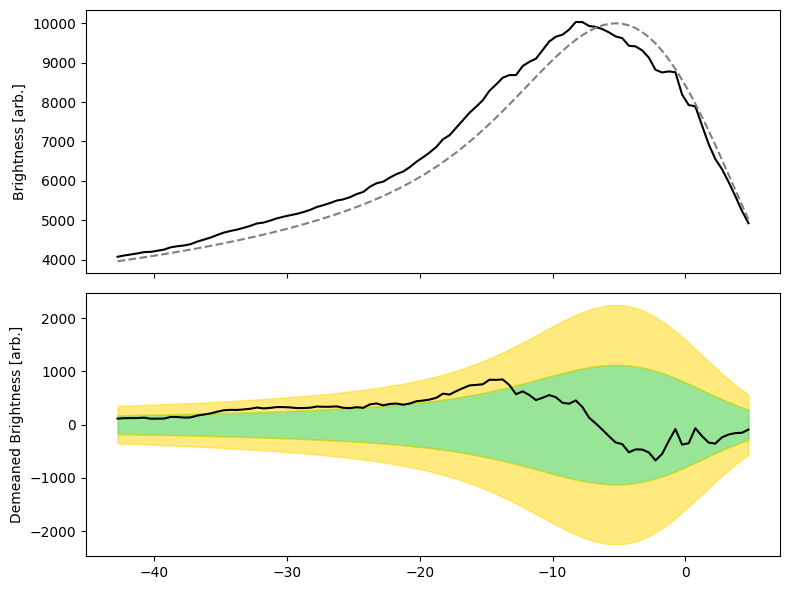

In [175]:
fig, axs = plt.subplots(nrows = 2, figsize = (8, 6))

axs[0].plot(t_evals, fake_data, color = 'black')
axs[0].plot(t_evals, true_mean, color = 'grey', ls = '--')
axs[0].set_xticklabels([])
axs[0].set_ylabel('Brightness [arb.]')

axs[1].plot(t_evals, fake_data-true_mean, color = 'black')
axs[1].fill_between(t_evals, -np.sqrt(np.diag(true_cov)), np.sqrt(np.diag(true_cov)), color = 'limegreen', alpha = .5)
axs[1].fill_between(t_evals, -np.sqrt(np.diag(true_cov)), -2*np.sqrt(np.diag(true_cov)), color = 'gold', alpha = .5)
axs[1].fill_between(t_evals, np.sqrt(np.diag(true_cov)), 2*np.sqrt(np.diag(true_cov)), color = 'gold', alpha = .5)
axs[1].set_ylabel('Demeaned Brightness [arb.]')

plt.tight_layout()
plt.show()


In [169]:
m = Minuit(NegLL, param_vec)
for i in range(bounds.shape[0]):
    m.limits['x'+str(i)] = bounds[i]

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 871.3                      │              Nfcn = 465              │
│ EDM = 0.0369 (Goal: 0.0002)      │           time = 74.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    1e1    │    0e1    │            │            │    5    │   15    │       │
│ 1 │ x1   │  1.0009   │  0.0000   │            │            │   0.9   │   1.1   │       │
│ 2 │ x2   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 3 │ x3   │   50.0    │    0.5    │            │            │         │         │  yes  │
│ 4 │ x4   │  -5.9998  │  0.0000   │            │            │   -10   │   -1    │       │
│ 5 │ x5   │ 8.9744e-3 │ 0.0000e-3 │            │            │ 0.0001  │    1    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [170]:
fraction_profile = m.mnprofile('x5', grid = np.logspace(-4, .1, 51), subtract_min = True)

m.minos('x5', cl = .9)
upper_lim = m.values['x5'] + m.merrors['x5'].upper 
print(upper_lim)
print(m.merrors['x5'].upper )

/home/nblinov/miniconda3/envs/microlensing/lib/python3.12/site-packages/iminuit/minuit.py:1627: IMinuitWarning: MIGRAD fails to converge for x5=0.0001
  warnings.warn(
/home/nblinov/miniconda3/envs/microlensing/lib/python3.12/site-packages/iminuit/minuit.py:1627: IMinuitWarning: MIGRAD fails to converge for x5=0.00012078138351067798
  warnings.warn(
/home/nblinov/miniconda3/envs/microlensing/lib/python3.12/site-packages/iminuit/minuit.py:1627: IMinuitWarning: MIGRAD fails to converge for x5=0.00014588142602753489
  warnings.warn(
/home/nblinov/miniconda3/envs/microlensing/lib/python3.12/site-packages/iminuit/minuit.py:1627: IMinuitWarning: MIGRAD fails to converge for x5=0.0001761976046411629
  warnings.warn(
/home/nblinov/miniconda3/envs/microlensing/lib/python3.12/site-packages/iminuit/minuit.py:1627: IMinuitWarning: MIGRAD fails to converge for x5=0.0002128139045982711
  warnings.warn(
/home/nblinov/miniconda3/envs/microlensing/lib/python3.12/site-packages/iminuit/minuit.py:1627: IM

ValueError: A value (662017557972304.2) in x_new is above the interpolation range's maximum value (651102824282881.2).

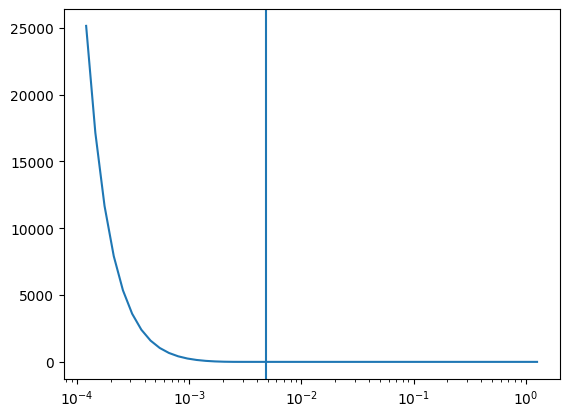

In [174]:
plt.plot(fraction_profile[0][1:], fraction_profile[1][1:])
plt.axvline(upper_lim)
plt.xscale('log')



## Fake data from a lens map.
In this subsection we use the full lens equation to generate the fake data. However, we still use the perturbative model to fit this data. 
The parameters of the lens model are chosen to match those of the above example. This mapping between the approximate and correct model, however is not exact, because the full lens model contains additional parameters (as encoded by the various derivatives of the Fermat potential $\phi_{ijk}$

In [136]:
def get_mu_gaussian_source(y, params):
    peak_mag, r_source_angular = params
    #print(peak_mag*src.analytic_gaussian_source_magnification(0.))
    #print(y/r_source_angular)
    #print("Peak mag parameter = ", peak_mag)
    #print("yvals = ", y)
    return(np.array([peak_mag*src.analytic_gaussian_source_magnification(-ypos/r_source_angular) for ypos in y]))


def pool_func(shared_y1_info, shared_y2_info, pixel_size_lns, rad, src_pos):

    shared_y1_name, y1_shape = shared_y1_info
    shared_y2_name, y2_shape = shared_y2_info
    existing_shm_y1 =  shared_memory.SharedMemory(name=shared_y1_name)
    existing_shm_y2 =  shared_memory.SharedMemory(name=shared_y2_name)
    
    y1 =  np.ndarray(y1_shape,dtype=np.float64,buffer=existing_shm_y1.buf)
    y2 =  np.ndarray(y2_shape,dtype=np.float64,buffer=existing_shm_y2.buf)
    
    lensed_source = src.gaussian_source(y1, y2, rad, c=src_pos)

    # Calculate magnifications
    intensity_norm = 1. # assume it is normalized #np.sum(a_gaussian) * ys * ys
    mag = np.sum(lensed_source) * (pixel_size_lns[0] * pixel_size_lns[1]) / intensity_norm
    return(mag)

def generate_lightcurve(params, num_pixel=1501, include_substructure=True):


    y_evals = -t_evals*1e3*3600*params['source_velocity']/(params['ps_params']['DS']*Gpc_in_km)/microarcsec
    rad = params['R']

    src_positions = np.array([[0.,ypos] for ypos in y_evals])
   
    padded_source_path_length = np.abs(np.max(y_evals) - np.min(y_evals)) + 15.*rad
    
    # Size and discretization of the lens and source planes
    num_pixel_lns, num_pixel_src = num_pixel, num_pixel # Number of pixels in both planes
    half_size_lns = np.array([60.*rad, 2*np.sqrt(params['caustic_params']['phi_222']/rad)])
    half_size_src = padded_source_path_length/2. # Half size of the lens and source planes
    pixel_size_lns = 2.0 * half_size_lns / (num_pixel_lns - 1)
    pixel_size_src = 2.0 * half_size_src / (num_pixel_src - 1) # horizontal and vertical physical pixel size
    
    # Random noise - make sure parameters supplied to power spectrum are in radians
    deflection_params = {'pixel_size_in_rad':pixel_size_lns*microarcsec, 'num_pixel':num_pixel_lns, 'area_in_rad_sq': half_size_lns[0]*half_size_lns[1]*microarcsec**2} 
    #Parameters needed for power spectrum here

    deflection_params['ps_params'] = params['ps_params']
    if include_substructure:
        # the output is in rad, so convert it to microarcsec
        caustic_params['random_deflection'] = random_deflection.generate_random_field(deflection_params)/microarcsec
    else:
        caustic_params['random_deflection'] = None
    
    # indices for the lens plane pixels.
    # Note: arrays are indexed as by [j1,j2], so j2 (j1) indexes horizontal (vertical) directions
    j1, j2 = np.mgrid[0:num_pixel_lns, 0:num_pixel_lns] 
    
    # this maps pixels indices to physical coord as [0,0] -> (-L,L), [0,N-1]-> (L,L) etc
    x1, x2 = pixel_to_pos(j2, -half_size_lns[0], pixel_size_lns[0]), pixel_to_pos(j1, half_size_lns[1], -pixel_size_lns[1])

    y1, y2 = lens_mapping(x1, x2, params['caustic_params'])
    
    # Convert deflected coordinates to source plane pixels
    i1, i2 = pos_to_pixel(y2, half_size_src, -pixel_size_src), pos_to_pixel(y1, -half_size_src, pixel_size_src)




    # Make some plots of the source  --------------------
    for ypos in y_evals[::10]:
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 3))
        ax1.set_title('Source Plane')
        ax2.set_title('Image Plane')
        j1_src, j2_src = np.mgrid[0:num_pixel_src,0:num_pixel_src]
        y1_full_src, y2_full_src = pixel_to_pos(j2_src, -half_size_src, pixel_size_src), pixel_to_pos(j1_src, half_size_src, -pixel_size_src)
    
        src_plane = ax1.imshow(src.gaussian_source(y1_full_src, y2_full_src, rad, c=[0,ypos]),vmin=0,\
                           extent=(-half_size_src,half_size_src,-half_size_src,half_size_src))
        img_plane = ax2.imshow(src.gaussian_source(y1,y2, rad, c=[0.,ypos]),vmin=1e6,vmax=1e7, \
                          extent=(-half_size_lns[0],half_size_lns[0],-half_size_lns[1],half_size_lns[1]), aspect=half_size_lns[0]/half_size_lns[1])
        ax1.set_xlabel(r'$y_1$ [$\mu$as]',fontsize=16)
        ax1.set_ylabel(r'$y_2$ [$\mu$as]',fontsize=16)
        ax2.set_xlabel(r'$x_1$ [$\mu$as]',fontsize=16)
        ax2.set_ylabel(r'$x_2$ [$\mu$as]',fontsize=16)
        divider1 = make_axes_locatable(ax1)
        cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    
        cbar = fig.colorbar(src_plane, cax=cax1)
        cbar = fig.colorbar(img_plane)
        fig.tight_layout()
        plt.show()
    # -------------------------------------------------------------------
    
    # create shared memory so that large static arrays don't get copied to workers
    shm_y1 = shared_memory.SharedMemory(create=True, size=y1.nbytes)
    shm_y2 = shared_memory.SharedMemory(create=True, size=y2.nbytes)
    y1_shared = np.ndarray(y1.shape, dtype=y1.dtype, buffer=shm_y1.buf)
    y1_shared[:] = y1[:]
    y2_shared = np.ndarray(y2.shape, dtype=y2.dtype, buffer=shm_y2.buf)
    y2_shared[:] = y2[:]
    y1_shape = y1.shape
    y2_shape = y2.shape

    magnifications = []
    with Pool() as p:
        #for mag in tqdm.tqdm(p.imap(func=partial(pool_func, [shm_y1.name, y1_shape], [shm_y2.name,y2_shape], rad), iterable=src_positions), total=len(src_positions)):    
        for mag in p.imap(func=partial(pool_func, [shm_y1.name, y1_shape], [shm_y2.name,y2_shape], pixel_size_lns, rad), iterable=src_positions):        
            magnifications.append(mag)
    magnifications = np.array(magnifications)

    return(magnifications)


In [154]:
# Data parameters in the same format as in the approximate model
bounds = np.array([[5, 15], [.9, 1.1], [1, 1], [50, 50], [-10, -1], [0.0001, 1]])
param_vec = [10, 1, 1, 50, -6, 1e-3]
noise, peak_mag, source_velocity, source_radius, M, frac = param_vec
M = 10**M

ps_params = {'M':M, 'c': 1000, 'DL': 1.35, 'DS':1.79, 'DLS':0.95, 'dm_mass_fraction':frac}

R = source_radius*r_sun/(ps_params['DS']*Gpc_in_km)/microarcsec # angular radius in microarcsec

mu_peak = 1e4*peak_mag

# Parameters that determine the lens equation near the caustic - see Schneider, Ehlers and Falco Ch. 6
phi_11, phi_22 = 0.8, 0.0 # This makes the caustic a horizontal line in the source plane
# the lightcurve for a gaussian peaks at y/R = -0.54 
phi_222 = 2.*src.analytic_gaussian_source_magnification(-0.540902)**2/(R*phi_11**2 * mu_peak**2)
# These are chosen such that the caustic is well approximated by a parabola, i.e. so that we can compare with analytics
phi_111, phi_112, phi_122 = 0.06/10., 0.05/10., 0.03/10.
caustic_params = {'phi_11':phi_11, 'phi_22':phi_22, 'phi_111':phi_111, 'phi_112':phi_112, 'phi_122':phi_122, 'phi_222':phi_222}

# Dictionary used by gen_model which is used by NegLL
fixed_params = {'phi_11': caustic_params['phi_11'],  'c': ps_params['c'], 'DS' : ps_params['DS']}

true_params = {'R': R, 'source_velocity':source_velocity}
true_params['caustic_params'] = caustic_params
true_params['ps_params'] = ps_params

g = 2 / (phi_11 ** 2 * phi_222)
peak_mag = np.sqrt(g / R)/1e4 
y_evals = -t_evals*1e3*3600*source_velocity/(ps_params['DS']*Gpc_in_km)/microarcsec
true_mean = get_mu_gaussian_source(y_evals, [1e4*peak_mag, R])

In [141]:
R

0.00013002071922911724

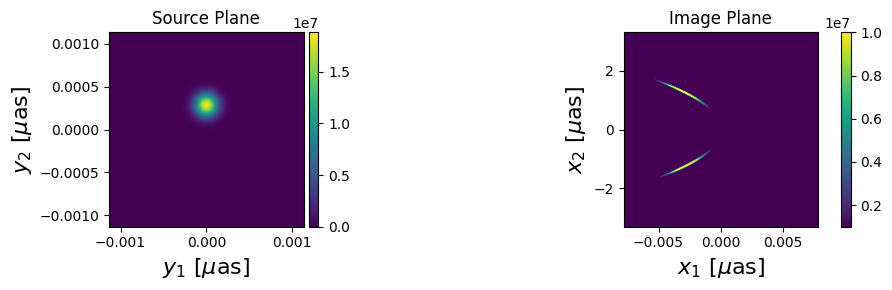

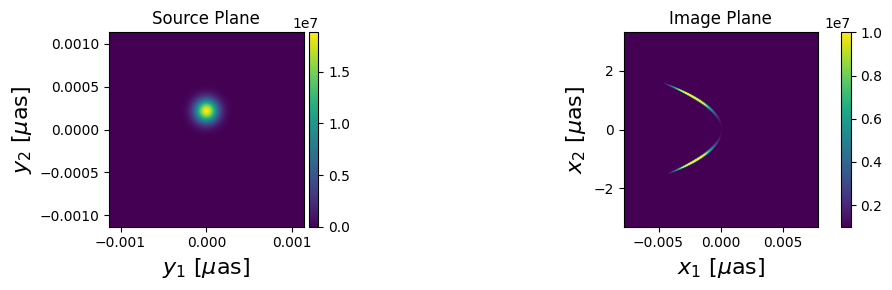

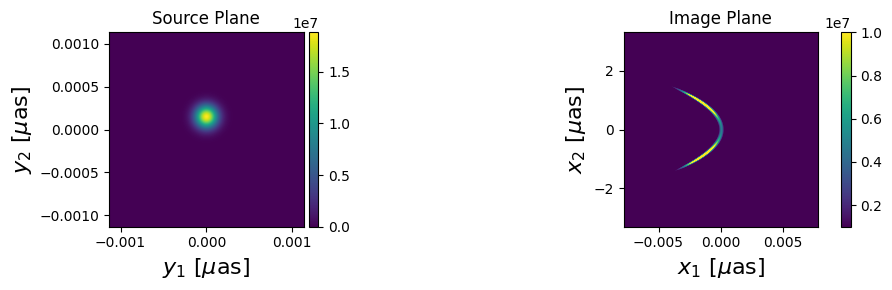

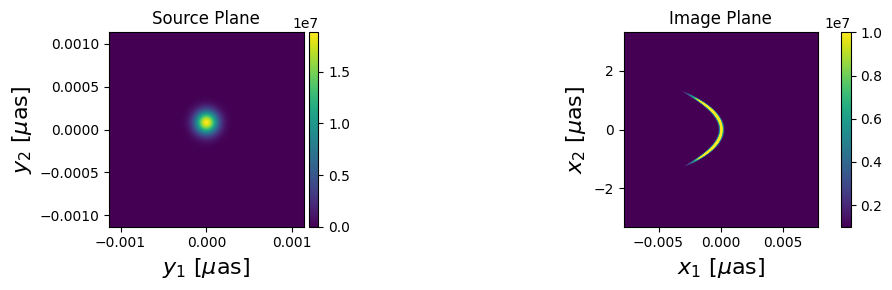

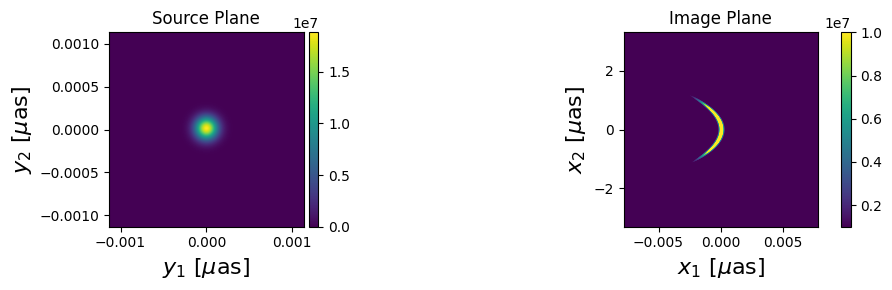

Text(0, 0.5, 'Magnification')

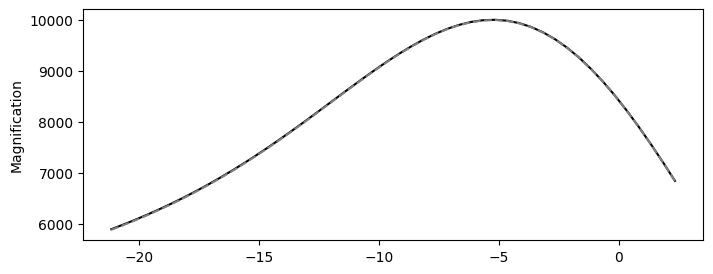

In [150]:
# Check that no perturbations gives a sensible lightcurve (i.e. one that matches analytics)
fake_data = generate_lightcurve(true_params, num_pixel=2001, include_substructure=False)

fig = plt.subplots(figsize = (8, 3))

plt.plot(t_evals, fake_data, color = 'black')
plt.plot(t_evals, true_mean, color = 'grey', ls = '--')

plt.ylabel('Magnification')


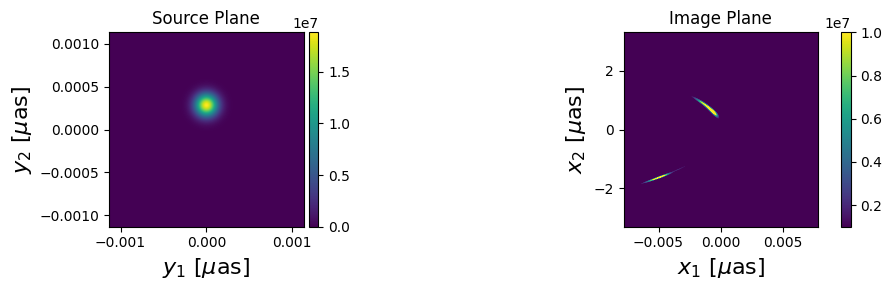

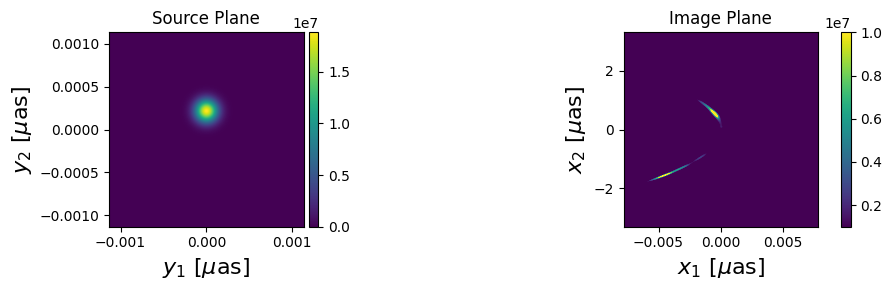

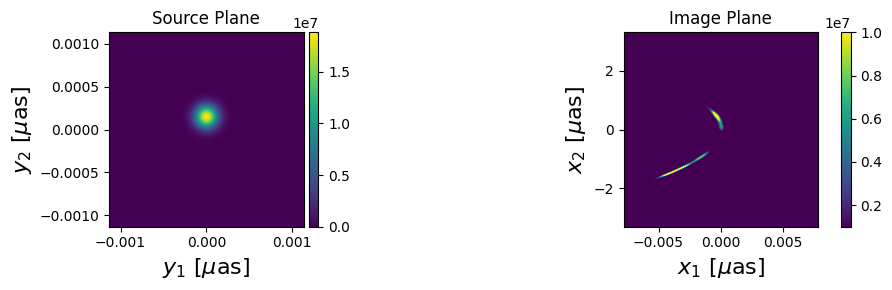

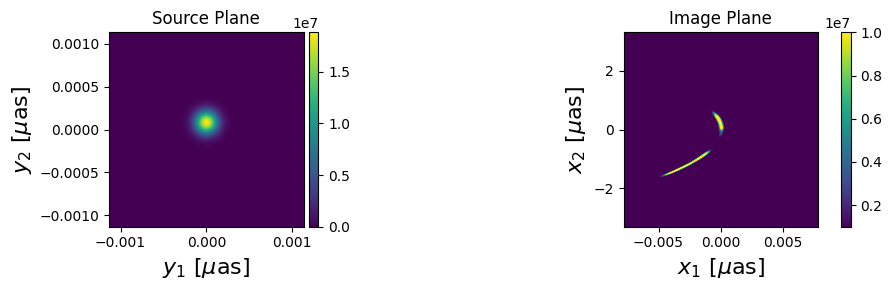

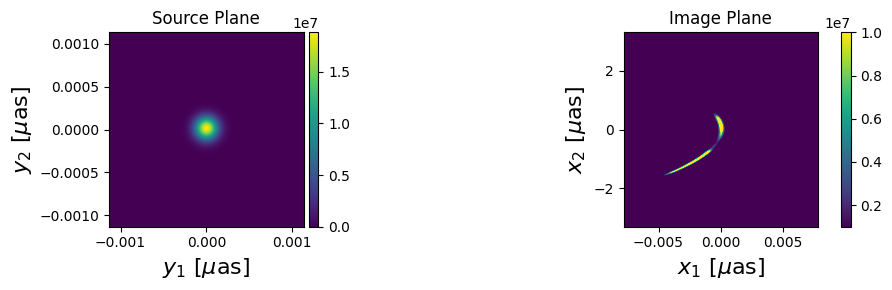

Text(0, 0.5, 'Magnification')

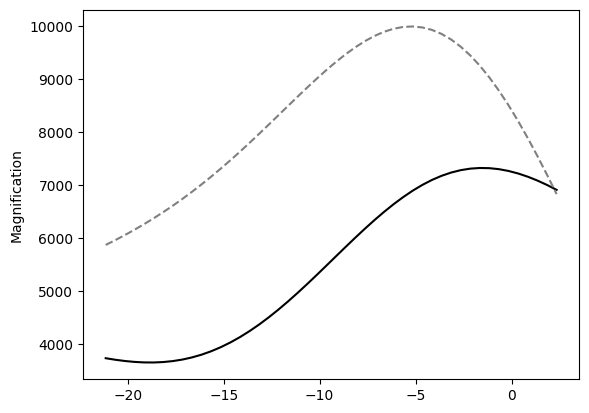

In [151]:
# Finally include convergence fluctuations
# The likelihood function NegLL uses the global fake_data so it has to have this name here
fake_data = generate_lightcurve(true_params, num_pixel=2001, include_substructure=True)
plt.plot(t_evals, fake_data, color = 'black')
plt.plot(t_evals, true_mean, color = 'grey', ls = '--')

plt.ylabel('Magnification')



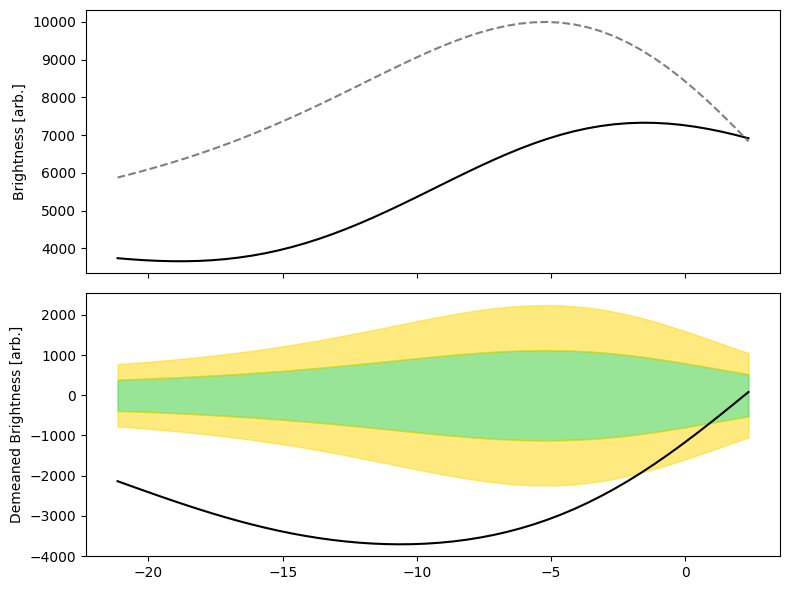

In [152]:
fig, axs = plt.subplots(nrows = 2, figsize = (8, 6))

axs[0].plot(t_evals, fake_data, color = 'black')
axs[0].plot(t_evals, true_mean, color = 'grey', ls = '--')
axs[0].set_xticklabels([])
axs[0].set_ylabel('Brightness [arb.]')

axs[1].plot(t_evals, fake_data-true_mean, color = 'black')
axs[1].fill_between(t_evals, -np.sqrt(np.diag(true_cov)), np.sqrt(np.diag(true_cov)), color = 'limegreen', alpha = .5)
axs[1].fill_between(t_evals, -np.sqrt(np.diag(true_cov)), -2*np.sqrt(np.diag(true_cov)), color = 'gold', alpha = .5)
axs[1].fill_between(t_evals, np.sqrt(np.diag(true_cov)), 2*np.sqrt(np.diag(true_cov)), color = 'gold', alpha = .5)
axs[1].set_ylabel('Demeaned Brightness [arb.]')

plt.tight_layout()
plt.show()


In [155]:


m = Minuit(NegLL, param_vec)
for i in range(bounds.shape[0]):
    m.limits['x'+str(i)] = bounds[i]

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 721.5                      │              Nfcn = 123              │
│ EDM = 2.49e-05 (Goal: 0.0002)    │            time = 4.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    10     │     7     │            │            │    5    │   15    │       │
│ 1 │ x1   │   1.100   │   0.006   │            │            │   0.9   │   1.1   │       │
│ 2 │ x2   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 3 │ x3   │   50.0    │    0.5    │            │            │         │         │  yes  │
│ 4 │ x4   │   -2.76   │   0.10    │            │            │   -10   │   -1    │       │
│ 5 │ x5   │  4.53e-3  │  0.28e-3  │            │            │ 0.0001  │    1    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5 │
├────┼─────────────────────────────────────────────────────────────┤
│ x0 │        50         0         0         0      0.00         0 │
│ x1 │         0  7.69e-13         0         0 2.2972e-9   4.1e-12 │
│ x2 │         0         0         0         0      0.00         0 │
│ x3 │         0         0         0         0      0.00         0 │
│ x4 │      0.00 2.2972e-9      0.00      0.00   0.00965  27.81e-6 │
│ x5 │         0   4.1e-12         0         0  27.81e-6  8.04e-08 │
└────┴─────────────────────────────────────────────────────────────┘

In [159]:
fraction_profile = m.mnprofile('x5', grid = np.logspace(-4, .1, 51), subtract_min = True)

m.minos('x5', cl = .9)
upper_lim = m.values['x5'] + m.merrors['x5'].upper 
print(upper_lim)
print(m.merrors['x5'].upper )

/home/nblinov/miniconda3/envs/microlensing/lib/python3.12/site-packages/iminuit/minuit.py:1627: IMinuitWarning: MIGRAD fails to converge for x5=0.0001
  warnings.warn(
/home/nblinov/miniconda3/envs/microlensing/lib/python3.12/site-packages/iminuit/minuit.py:1627: IMinuitWarning: MIGRAD fails to converge for x5=0.00012078138351067798
  warnings.warn(
/home/nblinov/miniconda3/envs/microlensing/lib/python3.12/site-packages/iminuit/minuit.py:1627: IMinuitWarning: MIGRAD fails to converge for x5=0.00014588142602753489
  warnings.warn(
/home/nblinov/miniconda3/envs/microlensing/lib/python3.12/site-packages/iminuit/minuit.py:1627: IMinuitWarning: MIGRAD fails to converge for x5=0.0001761976046411629
  warnings.warn(
/home/nblinov/miniconda3/envs/microlensing/lib/python3.12/site-packages/iminuit/minuit.py:1627: IMinuitWarning: MIGRAD fails to converge for x5=0.0002128139045982711
  warnings.warn(
/home/nblinov/miniconda3/envs/microlensing/lib/python3.12/site-packages/iminuit/minuit.py:1627: IM

0.0048108938636931345
0.0002835507845500001


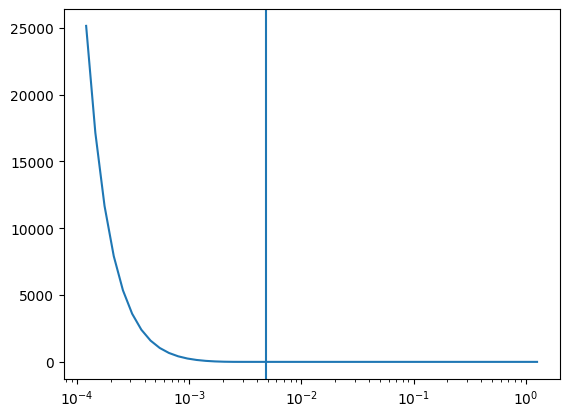

In [160]:
plt.plot(fraction_profile[0][1:], fraction_profile[1][1:])
plt.axvline(upper_lim)
plt.xscale('log')